In [6]:
import sys
sys.path.append(r'/Users/khbhavsar/Library/CloudStorage/OneDrive-UniversityofWaterloo/UNI Essentials/4A F2023/PHYS 437A/ECCOv4-py')


from ecco_download import ecco_podaac_download

By the end of this tutorial, we should be able to:
- Download ECCO fields using xarray
- Plot ECCO fields on a single tile
- Carry out spatial differencing and interpolation on the native model grid
- Compare the two sides of the geostrophic balancee equations
- Compute geostrophic velocities
- Apply masks in 2-D spatial plots
- Use the package to plot global maps of ECCO fields
- Use a statistical measure to assess latitude and depth dependence of geostrophic balance

We have the following equations that represent geostrophic flows.

$$f v = \frac{1}{\rho}\frac{\partial p}{\partial x}$$
$$f u = - \frac{1}{\rho}\frac{\partial p}{\partial y}$$

$f = 2 \Omega \sin(\theta)$ is a function of the latitude, v and u are part of the velocity field. We also have the pressure and density fields as part of the equations. As a result, we need all of these fields downloaded to study this kind of flows.

The velocity field is given by UVEL and VVEL. The density is given by RHOAnoma (density anomaly). We measure density as a variation with reference to the mean density ($1029 kg/m^3$) because density variations are very small in the ocean. Pressure is given by PHIHYD (hydrostatic pressure anomaly) and PHIHYDcR (hydrostatic pressure anomaly at constant depth).

In the tutorial, we download these data for January of 2000.

In [7]:
help(ecco_podaac_download)

Help on function ecco_podaac_download in module ecco_download:

ecco_podaac_download(ShortName, StartDate, EndDate, download_root_dir=None, n_workers=6, force_redownload=False)
    This routine downloads ECCO datasets from PO.DAAC. It is adapted from the Jupyter notebooks created by Jack McNelis and Ian Fenty (https://github.com/ECCO-GROUP/ECCO-ACCESS/blob/master/PODAAC/Downloading_ECCO_datasets_from_PODAAC/README.md) and modified by Andrew Delman (https://ecco-v4-python-tutorial.readthedocs.io).
    
    Parameters
    ----------
    ShortName: the ShortName of the dataset (can be identified from https://search.earthdata.nasa.gov/search?fpj=ECCO, selecting the "i" information button and the ShortName will appear in a gray box in the upper-left corner)
    
    StartDate: the start of the time range to be downloaded, expressed in the format "YYYY-MM-DD"
    
    EndDate: the end of the time range to be downloaded, expressed in the format "YYYY-MM-DD"
    
    download_root_dir: path of

In [8]:
# download file (granule) containing Jan 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
# ecco_podaac_download(ShortName=vel_monthly_shortname,\
#                     StartDate="2000-01-02",EndDate="2000-01-31",download_root_dir=None,\
#                     n_workers=6,force_redownload=False)

In [9]:
# download file (granule) containing Jan 2000 density/pressure anomalies,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
# ecco_podaac_download(ShortName=denspress_monthly_shortname,\
#                     StartDate="2000-01-02",EndDate="2000-01-31",download_root_dir=None,\
#                     n_workers=6,force_redownload=False)

In [10]:
# download file (granule) containing 01 Jan 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_daily_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_DAILY_V4R4"
# ecco_podaac_download(ShortName=vel_daily_shortname,\
#                     StartDate="2000-01-01",EndDate="2000-01-01",download_root_dir=None,\
#                     n_workers=6,force_redownload=False)
# download file (granule) containing 01 Jan 2000 density/pressure anomalies,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
denspress_daily_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_DAILY_V4R4"
# ecco_podaac_download(ShortName=denspress_daily_shortname,\
#                     StartDate="2000-01-01",EndDate="2000-01-01",download_root_dir=None,\
#                     n_workers=6,force_redownload=False)

In [11]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
# ecco_podaac_download(ShortName=grid_params_shortname,\
#                     StartDate="2000-01-01",EndDate="2000-01-01",download_root_dir=None,\
#                     n_workers=6,force_redownload=False)

In [12]:
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
import os
user_home_dir = expanduser(r'~')
sys.path.append(r'/Users/khbhavsar/Library/CloudStorage/OneDrive-UniversityofWaterloo/UNI Essentials/4A F2023/PHYS 437A/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

# locate files to load
download_root_dir = r'/Users/khbhavsar/Library/CloudStorage/OneDrive-UniversityofWaterloo/UNI Essentials/4A F2023/PHYS 437A/downloaded_data/ECCO_V4r4_PODAAC'
download_dir = join(download_root_dir,denspress_monthly_shortname)
curr_denspress_files = list(glob.glob(join(download_dir,'*nc')))
print(f'number of files to load: {len(curr_denspress_files)}')

# load file into workspace
# (in this case only 1 file, but this function can load multiple netCDF files with compatible dimensions)
ds_denspress_mo = xr.open_mfdataset(curr_denspress_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

number of files to load: 1


In [13]:
ds_denspress_mo

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    RHOAnoma   (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DRHODR     (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    PHIHYD     (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    PHIHYDcR   (time, k, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Density, Stratification, and ...
    uuid:                            166a1992-4182-11eb-82f9-0cc47a3f43f9

The boldface coordinates are dimensions. The other data variables are mostly indexed on coordinates (time, k, tile, j, i). There is only one month (Jan 2000), 50 vertical levels, 13 tiles, and each tile has a 90 x 90 horizontal grid.

In [14]:
ds_denspress_mo.RHOAnoma

<xarray.DataArray 'RHOAnoma' (time: 1, k: 50, tile: 13, j: 90, i: 90)>
dask.array<open_dataset-RHOAnoma, shape=(1, 50, 13, 90, 90), dtype=float32, chunksize=(1, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
    XC       (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    long_name:              In-situ seawater density anomaly
    units:                  kg m-3
    coverage_content_type:  modelResult
    valid_min:              -18.81316375732422
    valid_max:              25.540061950683594
    comment:                In-situ seawater density anomaly relative to the ...

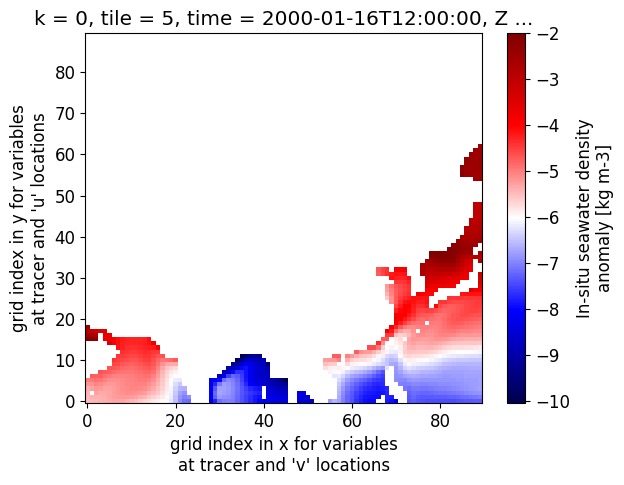

In [15]:
densanom = ds_denspress_mo.RHOAnoma
densanom_surf = densanom.isel(k=0)

plt.rcParams["font.size"] = 12    # set default font size for plots in this tutorial
densanom_surf_plot = (densanom_surf.isel(tile=5)).plot(cmap='seismic')

What if we want to plot the actual density and not just the anomaly?

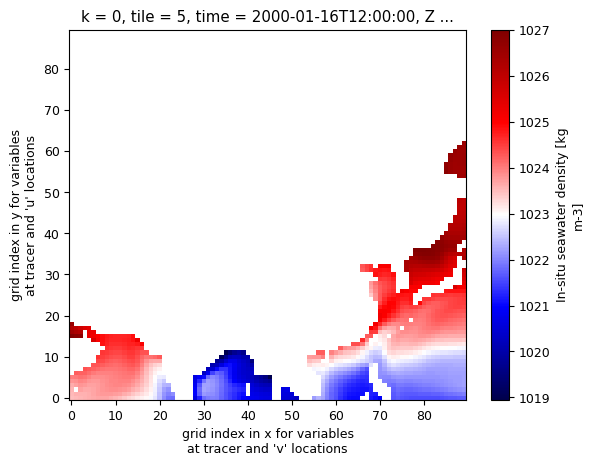

In [30]:
rhoConst = 1029
dens = densanom + rhoConst # rho_water = 1029 kg/m^3
dens.name = "RHO"
dens.attrs.update({'long_name': 'In-situ seawater density', 'units': 'kg m-3'})

dens_surf = dens.isel(k=0)
dens_surf_plot = (dens_surf.isel(tile=5)).plot(cmap='seismic')

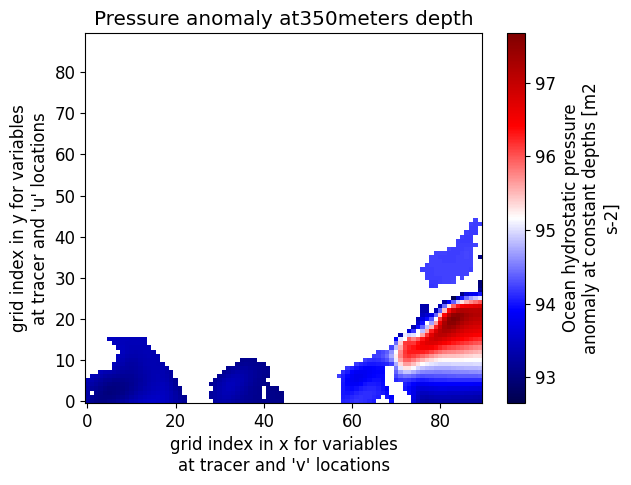

In [17]:
pressanom = ds_denspress_mo.PHIHYDcR
k_plot = 20

pressanom_plot = (pressanom.isel(tile=5, k=k_plot)).plot(cmap='seismic')
# change plot title to show depth of plotted level

depth_plot_level = -pressanom.Z[k_plot].values
plt.title('Pressure anomaly at' + str(int(depth_plot_level)) + 'meters depth')
plt.show()

In [18]:
pressanom

<xarray.DataArray 'PHIHYDcR' (time: 1, k: 50, tile: 13, j: 90, i: 90)>
dask.array<open_dataset-PHIHYDcR, shape=(1, 50, 13, 90, 90), dtype=float32, chunksize=(1, 50, 13, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
    XC       (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YC       (tile, j, i) float32 dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    Z        (k) float32 dask.array<chunksize=(50,), meta=np.ndarray>
Attributes:
    long_name:              Ocean hydrostatic pressure anomaly at constant de...
    units:                  m2 s-2
    coverage_content_type:  modelResult
    comment:                PHIHYD = p(k) / rhoConst - g z(k,t), where p = hy...
    valid_min:              78.17041778564453
    valid_max:              783.6217041015625

$$\text{PHIHYDcR} = \dfrac{p}{\rho} - gz$$

In [19]:
download_dir = join(download_root_dir,vel_monthly_shortname)
curr_velocity_files = list(glob.glob(join(download_dir,'*nc')))
print(f'number of files to load: {len(curr_denspress_files)}')

# load file into workspace
# (in this case only 1 file, but this function can load multiple netCDF files with compatible dimensions)
ds_velocity = xr.open_mfdataset(curr_velocity_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

number of files to load: 1


The $i_g$ and $j_g$ coordinates refer to horizontal dimensions centered on the $u$ and $v$ faces of each grid cell.

In [20]:
ds_velocity

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
                k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    UVEL       (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    VVEL       (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVEL       (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Velocity - Monthly Mean llc90...
    uuid:                            32bd652c-4182-11eb-bd5c-0cc47a3f82e7

Now, we need to calculate the gradient of pressure and for that we need the grid parameter files.

In [27]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_params_file = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
grid_params_file_path = join(download_root_dir,grid_params_shortname,grid_params_file)

# load grid parameters file
ds_grid = xr.open_dataset(grid_params_file_path)
ds_grid

<xarray.Dataset>
Dimensions:  (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50,
              k_p1: 51, tile: 13, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 ...
    Zu       (k_u) float32 ...
    Zl       (k_l) float32 ...
    XC_bnds  (tile, j, i, nb) float32 ...
    YC_bnds  (tile, j, i, nb) float32 ...
    Z_bnds   (k, nv) float32 ...
Dimensions without coordinates: nb, nv
Data variables: (12/21)
    CS       (tile, j, i) float32 ...
    SN       (tile, j, i) float32 ...
    rA       (tile, j, i) float32 ...
    dxG      (tile, j_g, i) float32 ...
    dyG      (tile, j, i_g) float32 ...
    Depth    (tile, j, i) float32 ...
    ...       ...
    hFacC    (k, tile, j, i) float32 ...
    hFacW    (k, tile, j, i_g) float32 ...
    hFacS    (k, tile, j_g, i) float32 ...
    maskC    (k, tile, j, i) bool ...
    maskW    (k, tile, j, i_g) bool ...
    maskS    (k, tile, j_g, i) bool ...
Attributes: (12/58)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    references:                      ECCO Consortium, Fukumori, I., Wang, O.,...
    source:                          The ECCO V4r4 state estimate was produce...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         This dataset provides geometric paramete...
    title:                           ECCO Geometry Parameters for the Lat-Lon...
    uuid:                            87ff7d24-86e5-11eb-9c5f-f8f21e2ee3e0

In [31]:
# create xgcm Grid object
xgcm_grid = ecco.get_llc_grid(ds_grid)

# compute derivatives of pressure in x and y
'''
since pressure is measured in the middle of the grid cell, we do not need to interpolate
the value while calculating its derivative. We can simply find the difference and divide
by the distance between the centres.
'''
d_press_dx = (xgcm_grid.diff(rhoConst * pressanom, axis='X', boundary='extend')) / ds_grid.dxC
d_press_dy = (xgcm_grid.diff(rhoConst * pressanom, axis='Y', boundary='extend')) / ds_grid.dyC

# convert DataArray content from dask to numpy arrays
# (dask arrays might have issues with interp_2d_vector fcn)
d_press_dx.data = d_press_dx.values
d_press_dy.data = d_press_dy.values

# interpolate (vector) gradient values to center of grid cells
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")    # use this to ignore future warnings caused by interp_2d_vector function
    press_grads_interp = xgcm_grid.interp_2d_vector({"X":d_press_dx,"Y":d_press_dy},boundary='extend')
dp_dx = press_grads_interp['X']
dp_dy = press_grads_interp['Y']
dp_dx.name = 'dp_dx'
dp_dy.name = 'dp_dy'

dp_dx

<xarray.DataArray 'dp_dx' (time: 1, k: 50, tile: 13, j: 90, i: 90)>
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [-1.78578217e-03, -2.80201435e-04,  4.48737061e-04, ...,
            2.56811129e-03,  2.54054624e-03,  2.38151103e-03],
          [-1.97579130e-03, -1.17824820e-04,  6.02442888e-04, ...,
            2.95511540e-03,  3.09964363e-03,  3.09713813e-03],
          [-1.60034164e-03,  3.31102929e-04,  6.47389097e-04, ...,
            3.22869234e-03,  3.55401146e-03,  3.75702744e-03]],

         [[-8.98729253e-04,  7.29348627e-04,  2.39784946e-04, ...,
            3.42662539e-03,  3.89235793e-03,  4.29460499e-03],
          [-2.40144931e-04,  7.03949365e-04, -7.84797710e-04, ...,
            3.54899094e-03,  4.10596048e-03,  4.68219491e-03],
          [ 5.17581939e-05,  1.75516907e-04, -2.09984998e-03, ...,
            3.58781964e-03,  4.15722188e-03,  4.85306140e-03],
...
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]]]]],
      dtype=float32)
Coordinates:
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: time